#LOAD DATA



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/data_clean.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepocessing

In [ ]:
cols = df.columns
for col in cols:
  print(df[col].value_counts())
  print('')

4    3426
3    3082
5    2281
6     994
2     613
7     246
Name: Customer_care_calls, dtype: int64

3    2171
1    2161
4    2122
2    2097
5    2091
Name: Customer_rating, dtype: int64

245    108
257    106
260    105
243    100
254     99
      ... 
107      5
120      5
96       5
122      4
99       4
Name: Cost_of_the_Product, Length: 215, dtype: int64

0    5173
1    4587
2     882
Name: Product_importance, dtype: int64

0    5356
1    5286
Name: Gender, dtype: int64

4883    11
1005    10
4741    10
1145    10
5783    10
        ..
3430     1
3262     1
1103     1
3487     1
1098     1
Name: Weight_in_gms, Length: 3984, dtype: int64

1    6282
0    4360
Name: Reached.on.Time_Y.N, dtype: int64

1.098612    3880
0.693147    2550
1.386294    2129
1.609438    1278
1.791759     549
1.945910     130
2.079442     126
Name: log_prior_purchases, dtype: int64

0.693147    847
2.302585    845
1.791759    839
2.197225    830
1.098612    829
           ... 
3.433987     37
3.258097     35


In [ ]:
cat = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
nums = ['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']

In [ ]:
df2 = df.copy()

In [ ]:
# Split data train dan data test (no Customer Rating, Gender)
df2 = df2.drop(columns=['Gender','Customer_rating'])

X= df2[['Warehouse_block_A','Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship',
        'Customer_care_calls','Cost_of_the_Product','log_prior_purchases','Product_importance','log_discount_offered','Weight_in_gms']]
y= df2['Reached.on.Time_Y.N']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=104, train_size=0.8)

In [ ]:
# Normalisasi
mm =  MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      10642 non-null  int64  
 1   Cost_of_the_Product      10642 non-null  int64  
 2   Product_importance       10642 non-null  int64  
 3   Weight_in_gms            10642 non-null  int64  
 4   Reached.on.Time_Y.N      10642 non-null  int64  
 5   log_prior_purchases      10642 non-null  float64
 6   log_discount_offered     10642 non-null  float64
 7   Mode_of_Shipment_Flight  10642 non-null  int64  
 8   Mode_of_Shipment_Road    10642 non-null  int64  
 9   Mode_of_Shipment_Ship    10642 non-null  int64  
 10  Warehouse_block_A        10642 non-null  int64  
 11  Warehouse_block_B        10642 non-null  int64  
 12  Warehouse_block_C        10642 non-null  int64  
 13  Warehouse_block_D        10642 non-null  int64  
 14  Warehouse_block_F     

In [ ]:
df2.describe()

,Customer_care_calls,Cost_of_the_Product,Product_importance,Weight_in_gms,Reached.on.Time_Y.N,log_prior_purchases,log_discount_offered,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
count,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000,10642.000000
mean,4.065683,210.578557,0.596786,3646.514189,0.590303,1.178075,1.961307,0.162375,0.160026,0.677598,0.166980,0.167074,0.166416,0.166980,0.332550
std,1.145348,48.077818,0.637518,1639.849048,0.491801,0.354866,1.055971,0.368812,0.366648,0.467418,0.372975,0.373059,0.372471,0.372975,0.471149
min,2.000000,96.000000,0.000000,1001.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,170.000000,0.000000,1837.000000,0.000000,1.098612,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,215.000000,1.000000,4172.000000,1.000000,1.098612,1.945910,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,251.000000,1.000000,5063.750000,1.000000,1.386294,2.302585,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,7.000000,310.000000,2.000000,7846.000000,1.000000,2.079442,4.110874,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df2.head()

,Customer_care_calls,Cost_of_the_Product,Product_importance,Weight_in_gms,Reached.on.Time_Y.N,log_prior_purchases,log_discount_offered,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
0,4,177,0,1233,1,1.098612,3.784190,1,0,0,0,0,0,1,0
1,4,216,0,3088,1,0.693147,4.077537,1,0,0,0,0,0,0,1
2,2,183,0,3374,1,1.386294,3.871201,1,0,0,1,0,0,0,0
3,3,176,1,1177,1,1.386294,2.302585,1,0,0,0,1,0,0,0
4,2,184,1,2484,1,1.098612,3.828641,1,0,0,0,0,1,0,0


# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import validation_curve


In [ ]:
def evaluate_model(model, prediction, X_train, y_train, X_test, y_test):
    # Calculate metrics for Data Train
    train_accuracy = accuracy_score(y_train, prediction[0])
    train_precision = precision_score(y_train, prediction[0])
    train_recall = recall_score(y_train, prediction[0])
    train_f1 = f1_score(y_train, prediction[0])
    train_roc_auc = roc_auc_score(y_train, prediction[0])

    # Print the metrics for Data Train
    print("Metrics for Data Train:")
    print(f"Accuracy: {train_accuracy:.2f}")
    print(f"Precision: {train_precision:.2f}")
    print(f"Recall: {train_recall:.2f}")
    print(f"F1 Score: {train_f1:.2f}")
    print(f"ROC AUC: {train_roc_auc:.2f}")

    # Calculate metrics for Data Test
    test_accuracy = accuracy_score(y_test, prediction[1])
    test_precision = precision_score(y_test, prediction[1])
    test_recall = recall_score(y_test, prediction[1])
    test_f1 = f1_score(y_test, prediction[1])
    test_roc_auc = roc_auc_score(y_test, prediction[1])

    # Print the metrics for Data Test
    print("\nMetrics for Data Test:")
    print(f"Accuracy: {test_accuracy:.2f}")
    print(f"Precision: {test_precision:.2f}")
    print(f"Recall: {test_recall:.2f}")
    print(f"F1 Score: {test_f1:.2f}")
    print(f"ROC AUC: {test_roc_auc:.2f}")

In [ ]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing data
y_test_pred = model.predict(X_test)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Evaluate the model using the evaluate_model function
evaluate_model(model, [y_train_pred, y_test_pred], X_train, y_train, X_test, y_test)

Metrics for Data Train:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC: 1.00

Metrics for Data Test:
Accuracy: 0.64
Precision: 0.74
Recall: 0.62
F1 Score: 0.67
ROC AUC: 0.64


In [ ]:
from sklearn.model_selection import cross_val_score

# Melakukan cross-validation untuk memeriksa overfitting atau underfitting
cv_scores_train = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall')
cv_scores_test = cross_val_score(rf_model, X_test, y_test, cv=5, scoring='recall')

# Menghitung rata-rata dari recall pada data pelatihan dan data pengujian
mean_recall_train = cv_scores_train.mean()
mean_recall_test = cv_scores_test.mean()

# Menampilkan hasil cross-validation
print(f'Mean Recall on Training Data: {mean_recall_train:.2f}')
print(f'Mean Recall on Testing Data: {mean_recall_test:.2f}')

# Mengecek apakah terdapat overfitting atau underfitting
if mean_recall_train > mean_recall_test:
    print("Model mengalami overfitting.")
elif mean_recall_train < mean_recall_test:
    print("Model mengalami underfitting.")
else:
    print("Model memiliki performa seimbang pada data pelatihan dan data pengujian.")


Mean Recall on Training Data: 0.55
Mean Recall on Testing Data: 0.65
Model mengalami underfitting.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, make_scorer

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Daftar hyperparameter yang akan dioptimalkan
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Membuat fungsi custom scorer untuk recall
scorer = make_scorer(recall_score)

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=10, scoring=scorer,
    n_jobs=-1, cv=5, random_state=42, verbose=2, return_train_score=True
)

# Melatih model dengan data training
random_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best Hyperparameters: ", random_search.best_params_)

# Menggunakan model dengan parameter terbaik
best_rf_model = random_search.best_estimator_

# Prediksi menggunakan data test
y_test_pred = best_rf_model.predict(X_test)
y_train_pred = best_rf_model.predict(X_train)

# Menghitung recall pada data test
recall = recall_score(y_test, y_pred)
print("Recall on Test Data: ", recall)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Recall on Test Data:  1.0


In [ ]:
# Prediksi probabilitas pada data pelatihan
y_train_pred_prob = rf_model.predict_proba(X_train)[:, 1]

# Prediksi probabilitas pada data uji
y_test_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Menentukan threshold yang baru (misalnya, 0.1)
new_threshold = 0.1

# Menggunakan threshold yang baru untuk membuat prediksi biner pada data pelatihan
y_train_pred = (y_train_pred_prob >= new_threshold).astype(int)

# Menggunakan threshold yang baru untuk membuat prediksi biner pada data uji
y_test_pred = (y_test_pred_prob >= new_threshold).astype(int)

# Menentukan model yang akan dievaluasi (dalam hal ini, rf_model)
model_to_evaluate = rf_model

# Memanggil fungsi evaluate_model
evaluate_model(model_to_evaluate, [y_train_pred, y_test_pred], X_train, y_train, X_test, y_test)

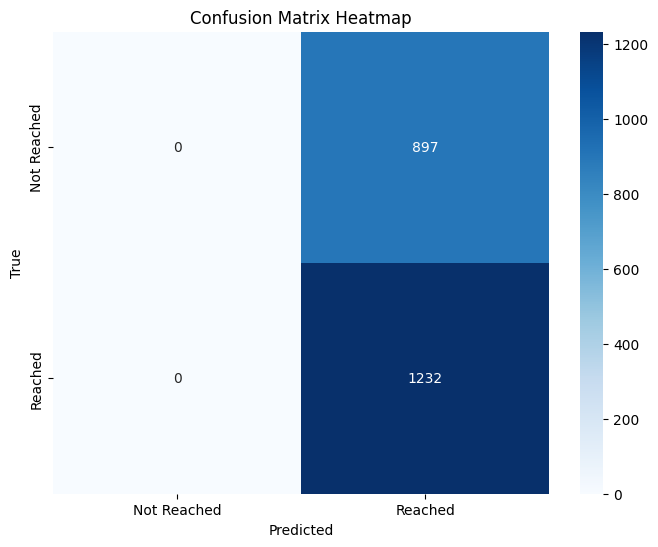

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Reached", "Reached"], yticklabels=["Not Reached", "Reached"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()

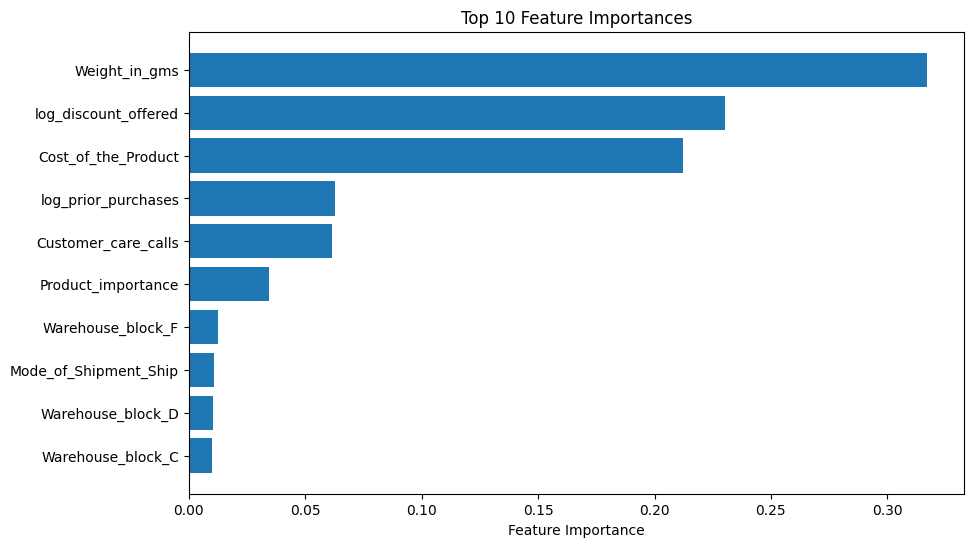

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the best random forest model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N most important features
top_n = 10  # Change this value to display the top N features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# kNN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    #

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Membuat model KNN
k = 50  # Jumlah tetangga dengan rumus k=√n dimana n adalah banyak jumlah data
knn = KNeighborsClassifier(n_neighbors=k)

# Melatih model KNN pada data pelatihan
knn.fit(X_train, y_train)

# Melakukan prediksi pada data pengujian
y_pred = knn.predict(X_test)

# Mengukur akurasi model
accuracy = accuracy_score(y_test, y_pred)
eval_classification(knn)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Menghitung confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

# Menghitung precision, recall, dan F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Menampilkan laporan klasifikasi
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Confusion Matrix:
[[549 298]
 [503 779]]
Precision: 0.72
Recall: 0.61
F1-score: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.65      0.58       847
           1       0.72      0.61      0.66      1282

    accuracy                           0.62      2129
   macro avg       0.62      0.63      0.62      2129
weighted avg       0.64      0.62      0.63      2129



In [ ]:
# Standarisasi fitur (opsional, namun seringkali bermanfaat)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Membuat model KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Ganti dengan hyperparameter terbaik Anda

# Melakukan cross-validation dengan model KNN
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring="recall")

# Menampilkan hasil cross-validation
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Mengukur kinerja model pada data uji
knn.fit(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)
print("Test Set Recall:", test_accuracy)

Cross-Validation Scores: [0.62184381 0.64004698 0.64944216 0.6186839  0.64101058]
Mean CV Accuracy: 0.6342054837906148
Test Set Accuracy: 0.6265852512916862


In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 25, 50],  # Contoh nilai-nilai untuk k
    'weights': ['uniform', 'distance'],  # Contoh metode pembobotan
    'p': [1, 2]  # Contoh nilai p (1 untuk Manhattan distance, 2 untuk Euclidean distance)
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Melakukan penelusuran pada data pelatihan
grid_search.fit(X, y)

# Menampilkan hyperparameter terbaik
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Menampilkan skor terbaik dari validasi silang
best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

Best Hyperparameters:
{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
Best Cross-Validation Score: 0.6256888404665963


In [ ]:
# Set hyperparameter sesuai dengan hasil tuning
best_params = {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

# Membuat model KNN dengan hyperparameter terbaik
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], p=best_params['p'], weights=best_params['weights'])

# Melatih model KNN pada data pelatihan
knn.fit(X_train, y_train)

# Melakukan prediksi pada data pengujian
y_pred = knn.predict(X_test)

# Mengukur akurasi model
accuracy = accuracy_score(y_test, y_pred)
eval_classification(knn)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Reached", "Reached"], yticklabels=["Not Reached", "Reached"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()

Dengan demikian, model KNN yang telah di-tune dapat digunakan untuk melakukan prediksi pada data dengan akurasi yang cukup baik.

#XGBoost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))

    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(15, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

In [ ]:

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#inisialisasi model
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

#metrik evaluasi model
y_pred = xg.predict(X_test)
eval_classification(xg, y_pred, X_train, y_train, X_test, y_test)


Accuracy (Test Set): 0.64
Precision (Test Set): 0.71
Recall (Test Set): 0.64
F1-Score (Test Set): 0.68
AUC: 0.64


In [ ]:
print('Train score: ' + str(xg.score(X_train, y_train)))
print('Test score:' + str(xg.score(X_test, y_test)))

Train score: 0.9030893926935275
Test score:0.6434945984030062


~overfit, karena perbedaan yang signifikan antara "Train score" (0.8952) dan "Test score" (0.6468). Perbedaan ini mengindikasikan bahwa model sangat baik dalam mempelajari data train, tetapi kinerjanya menurun secara substansial saat diuji pada data test. maka langkah selanjutnya adalah penyetelan hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 9)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned1 = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned1.fit(X_train,y_train)

# Predict & Evaluation
y_pred = xg_tuned1.predict(X_test)#Check performa dari model
eval_classification(xg_tuned1, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.64
Precision (Test Set): 0.70
Recall (Test Set): 0.67
F1-Score (Test Set): 0.68
AUC: 0.64


Setelah melakukan hyperparameter, ada peningkatan pada memerapa metrik evaluasi model yaitu:


*   Accuracy: Akurasi model sekarang adalah 0.66, yang merupakan peningkatan dari sebelumnya (0.65) menunjukkan bahwa model lebih baik dalam memprediksi pada data test
*   Precision: Presisi model meningkat menjadi 0.77 dari sebelumnya (0.72). Ini adalah perkembangan positif yang menunjukkan bahwa model lebih baik dalam menghindari prediksi positif yang salah.
*   Recall : Recall model mengalami penurunan menjadi 0.58 dari sebelumnya (0.65)
*   F1-Score: F1-Score yang baru adalah 0.66, yang menunjukkan bahwa model memiliki keseimbangan yang lebih baik antara presisi dan recall dibandingkan sebelumnya (0.68)
*  AUC: Nilai AUC sekarang adalah 0.67, yang mengindikasikan bahwa model memiliki kemampuan yang cukup baik dalam membedakan antara kelas positif dan negatif, dengan sedikit peningkatan dari sebelumnya (0.65).



In [ ]:
print('Train score: ' + str(xg_tuned1.score(X_train, y_train)))
print('Test score:' + str(xg_tuned1.score(X_test, y_test)))

Train score: 0.8586319307645464
Test score:0.7258529513964296


Test score memiliki nilai 0.7223, berarti ada peningkatan yang signifikan dari sebelumnya (0.6468) yang merupakan indikasi positif. Hal ini menunjukkan bahwa model lebih baik dalam menggeneralisasikan hasilnya ke data test yang belum pernah dilihat sebelumnya.

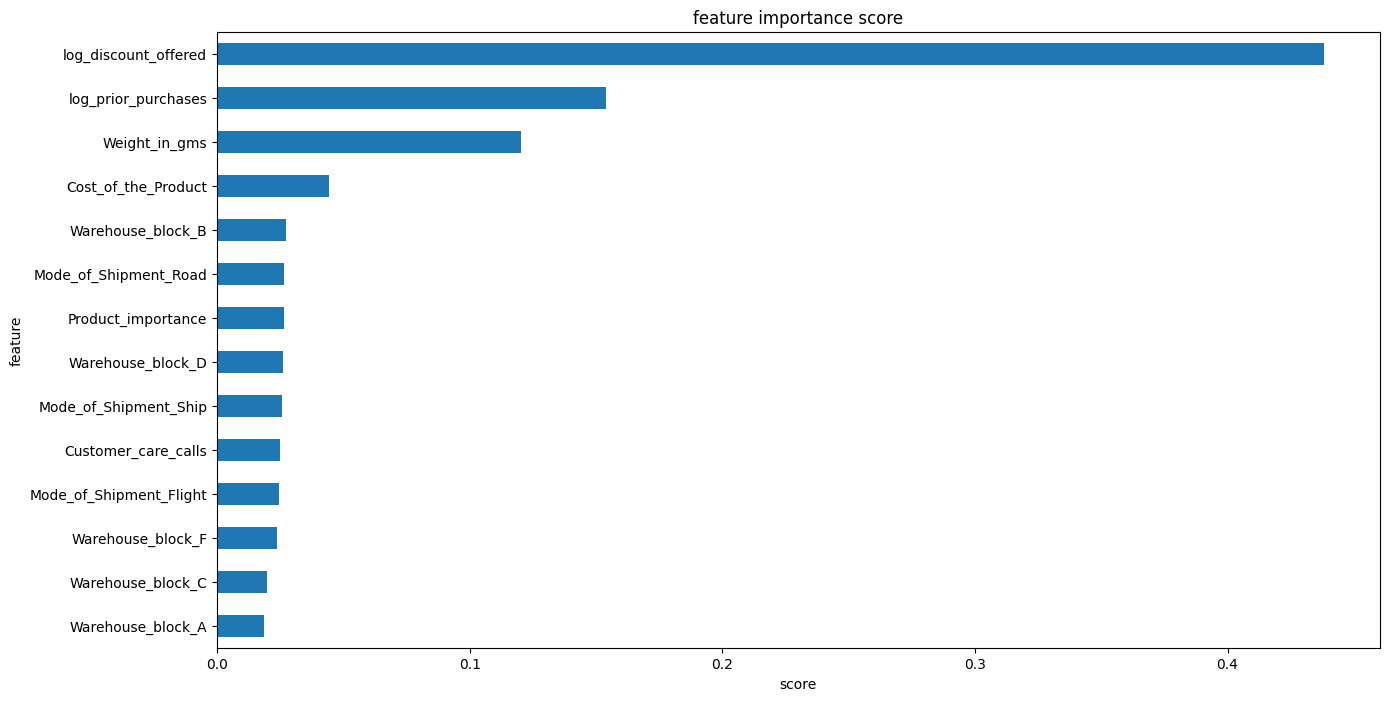

In [ ]:
show_feature_importance(xg_tuned1.best_estimator_)

In [ ]:
##############


In [ ]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#inisialisasi model
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg.fit(X_train, y_train)

# Model Evaluation - Pemilihan dan Perhitungan Metrics Model
y_pred = xg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.6434945984030062
Confusion Matrix:
 [[580 317]
 [442 790]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.60       897
           1       0.71      0.64      0.68      1232

    accuracy                           0.64      2129
   macro avg       0.64      0.64      0.64      2129
weighted avg       0.65      0.64      0.65      2129



In [ ]:
# Model Evaluation - Validasi dengan Cross-Validation
cv_scores = cross_val_score(xg, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
average_cv_score = np.mean(cv_scores)
print("Average Cross-Validation Score:", average_cv_score)


Cross-Validation Scores: [0.77360263 0.7933302  0.56578947 0.43984962 0.45112782]
Average Cross-Validation Score: 0.6047399499217748


In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, scoring='recall', cv=5)
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best Score: 0.5937910757085164


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    #

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
# Set hyperparameter sesuai dengan hasil tuning
best_params = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimator': '300'}

# Membuat model dengan hyperparameter terbaik
xgb = XGBClassifier(XGBClassifier=best_params['learning_rate'], max_depth=best_params['max_depth'], n_estimator=best_params['n_estimator'])

# Melatih model pada data pelatihan
xgb.fit(X_train, y_train)

# Melakukan prediksi pada data pengujian
y_pred = xgb.predict(X_test)

# Mengukur akurasi model
accuracy = accuracy_score(y_test, y_pred)
eval_classification(xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy (Test Set): 0.65
Precision (Test Set): 0.72
Recall (Test Set): 0.64
F1-Score (Test Set): 0.68
roc_auc (test-proba): 0.72
roc_auc (train-proba): 0.94
Accuracy: 64.73%


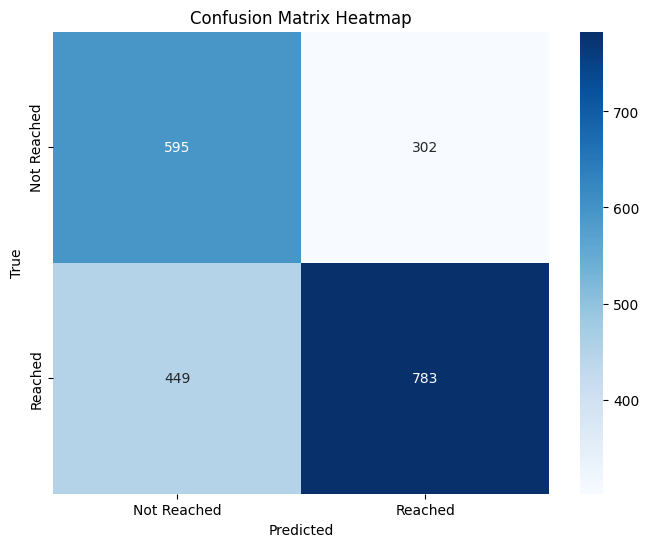

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Reached", "Reached"], yticklabels=["Not Reached", "Reached"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()

#Decission Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))  # Close the parenthesis here

    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1)
    print("AUC: %.2f" % auc(fpr, tpr))

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.71
Recall (Test Set): 0.70
F1-Score (Test Set): 0.71
AUC: 0.63


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 1.0
Test score:0.646782527007985


Hasil Train dan Test Score menunjukkan adanya overfitting

##Tune Hyperparameter with RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini', 'entropy']
splitter = ['best', 'random']

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.88
Recall (Test Set): 0.50
F1-Score (Test Set): 0.63
AUC: 0.70


In [ ]:
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])
print('Best criterion:', model.best_estimator_.get_params()['criterion'])
print('Best splitter:', model.best_estimator_.get_params()['splitter'])

Best max_depth: 8
Best min_samples_split: 10
Best min_samples_leaf: 4
Best max_features: auto
Best criterion: entropy
Best splitter: best


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train)))
print('Test score:' + str(model.score(X_test, y_test)))

Train score: 0.775219783660689
Test score:0.7248037028919173


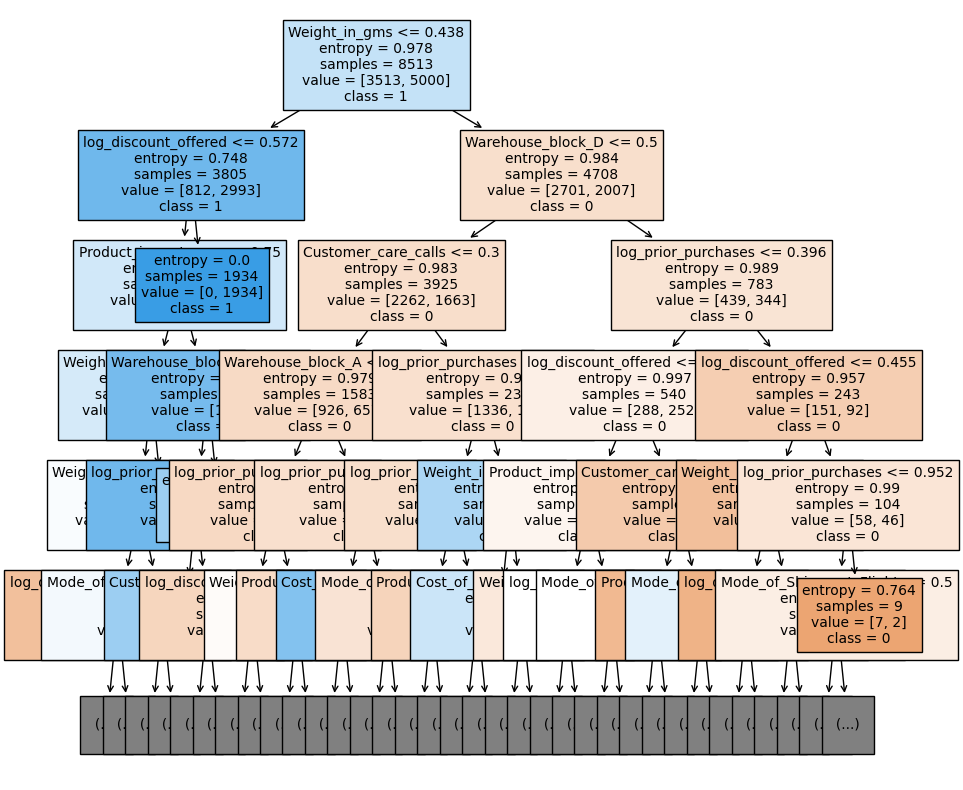

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(model.best_estimator_,
               feature_names = X.columns.tolist(),
               class_names=['0','1'],
               filled = True, max_depth=5, fontsize=10)
plt.show()


Text(0.5, 1.0, 'feature importance score')

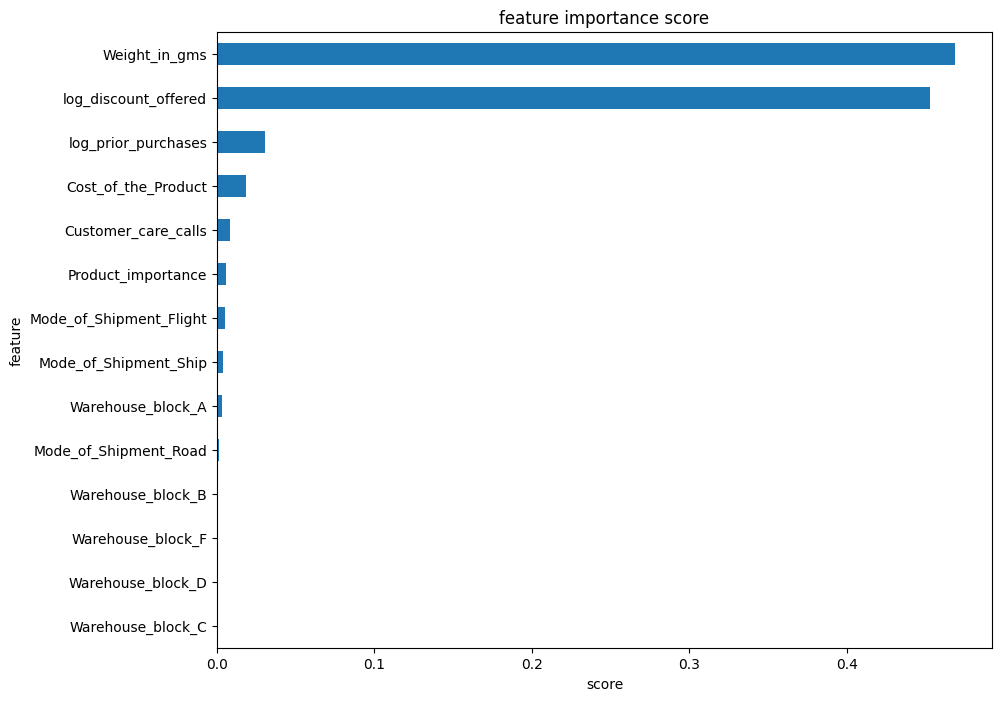

In [ ]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      10642 non-null  int64  
 1   Cost_of_the_Product      10642 non-null  int64  
 2   Product_importance       10642 non-null  int64  
 3   Weight_in_gms            10642 non-null  int64  
 4   Reached.on.Time_Y.N      10642 non-null  int64  
 5   log_prior_purchases      10642 non-null  float64
 6   log_discount_offered     10642 non-null  float64
 7   Mode_of_Shipment_Flight  10642 non-null  int64  
 8   Mode_of_Shipment_Road    10642 non-null  int64  
 9   Mode_of_Shipment_Ship    10642 non-null  int64  
 10  Warehouse_block_A        10642 non-null  int64  
 11  Warehouse_block_B        10642 non-null  int64  
 12  Warehouse_block_C        10642 non-null  int64  
 13  Warehouse_block_D        10642 non-null  int64  
 14  Warehouse_block_F     

##with feature selection

In [ ]:
X = df2.drop(columns=['Reached.on.Time_Y.N','Customer_care_calls','Product_importance','Mode_of_Shipment_Flight','Mode_of_Shipment_Road','Mode_of_Shipment_Ship','Warehouse_block_A','Warehouse_block_B','Warehouse_block_C','Warehouse_block_D','Warehouse_block_F'])
y = df2['Reached.on.Time_Y.N'] # target / label

#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.63
Precision (Test Set): 0.67
Recall (Test Set): 0.70
F1-Score (Test Set): 0.69
AUC: 0.62


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #accuracy
print('Test score:' + str(model.score(X_test, y_test))) #accuracy

Train score: 1.0
Test score:0.6298731798966651


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini', 'entropy']
splitter = ['best', 'random']

hyperparameters = dict(max_depth=max_depth,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model, y_pred, X_train, y_train, X_test, y_test)


Accuracy (Test Set): 0.66
Precision (Test Set): 0.72
Recall (Test Set): 0.67
F1-Score (Test Set): 0.69
AUC: 0.65


In [ ]:
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', model.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_features:', model.best_estimator_.get_params()['max_features'])
print('Best criterion:', model.best_estimator_.get_params()['criterion'])
print('Best splitter:', model.best_estimator_.get_params()['splitter'])

Best max_depth: 91
Best min_samples_split: 5
Best min_samples_leaf: 50
Best max_features: auto
Best criterion: entropy
Best splitter: best


In [ ]:
print('Train score: ' + str(model.score(X_train, y_train)))
print('Test score:' + str(model.score(X_test, y_test)))

Train score: 0.7941110694956298
Test score:0.734975622203883


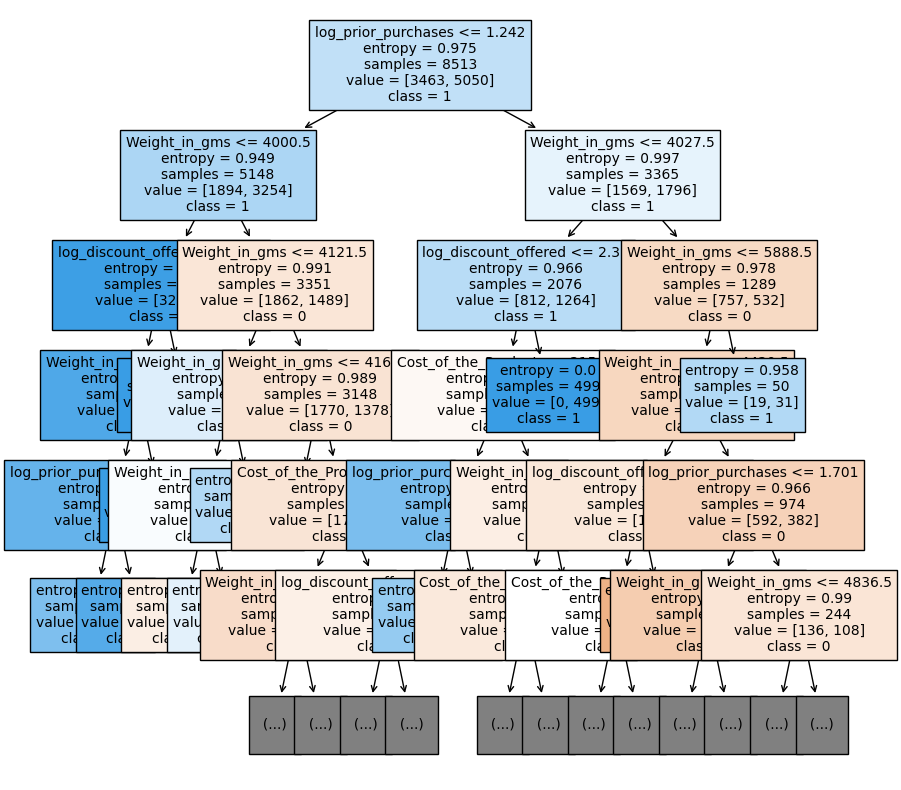

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(model.best_estimator_,
               feature_names = X.columns.tolist(),
               class_names=['0','1'],
               filled = True, max_depth=5, fontsize=10)
plt.show()

# LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10642 entries, 0 to 10641
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      10642 non-null  int64  
 1   Cost_of_the_Product      10642 non-null  int64  
 2   Product_importance       10642 non-null  int64  
 3   Weight_in_gms            10642 non-null  int64  
 4   Reached.on.Time_Y.N      10642 non-null  int64  
 5   log_prior_purchases      10642 non-null  float64
 6   log_discount_offered     10642 non-null  float64
 7   Mode_of_Shipment_Flight  10642 non-null  int64  
 8   Mode_of_Shipment_Road    10642 non-null  int64  
 9   Mode_of_Shipment_Ship    10642 non-null  int64  
 10  Warehouse_block_A        10642 non-null  int64  
 11  Warehouse_block_B        10642 non-null  int64  
 12  Warehouse_block_C        10642 non-null  int64  
 13  Warehouse_block_D        10642 non-null  int64  
 14  Warehouse_block_F     

In [ ]:
X = df2[['log_discount_offered', 'Weight_in_gms', 'log_prior_purchases', 'Cost_of_the_Product']]
y = df2['Reached.on.Time_Y.N'] # target / label

#Splitting the df2 into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    #

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train, y_train)

# hasil prediksi
y_pred = model_lgb.predict(X_test)

#
result = eval_classification(model_lgb)

[LightGBM] [Info] Number of positive: 5050, number of negative: 3463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 8513, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593210 -> initscore=0.377253
[LightGBM] [Info] Start training from score 0.377253
Accuracy (Test Set): 0.65
Precision (Test Set): 0.75
Recall (Test Set): 0.60
F1-Score (Test Set): 0.67
roc_auc (test-proba): 0.73
roc_auc (train-proba): 0.90


In [ ]:
print('Train score: ' + str(model_lgb.score(X_train, y_train)))
print('Test score:' + str(model_lgb.score(X_test, y_test)))

Train score: 0.8041818395395278
Test score:0.6524189760450916


#Hyperparameter Tuning

In [ ]:
#Hyperparameter Tuning
model = lgb.LGBMClassifier(num_learning_rate=0.09, leaves = 3, max_depth=2,random_state=42, num_iterations=132)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='roc_auc')
print(); print(model)

expectedy  = y_test
predictedy = model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Info] Number of positive: 5050, number of negative: 3463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 8513, number of used features: 4
[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593210 -> initscore=0.377253
[LightGBM] [Info] Start training from score 0.377253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [ ]:
result = eval_classification(model)

[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
[LightGBM] [Warning] Unknown parameter: num_learning_rate
[LightGBM] [Warning] Unknown parameter: leaves
Accuracy (Test Set): 0.68
Precision (Test Set): 0.89
Recall (Test Set): 0.51
F1-Score (Test Set): 0.64
roc_auc (test-proba): 0.74
roc_auc (train-proba): 0.77


In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='precision')

# Calculate the mean of cross-validation scores
mean_cv_score = cv_scores.mean()

print(f'Mean Cross-Validation: {mean_cv_score:.2f}')


[LightGBM] [Info] Number of positive: 4040, number of negative: 2770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 6810, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593245 -> initscore=0.377397
[LightGBM] [Info] Start training from score 0.377397
[LightGBM] [Info] Number of positive: 4040, number of negative: 2770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 6810, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593245 -> initscore=0.377397
[LightGBM] [Inf

In [ ]:
# Langkah E: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=model_lgb, param_grid=param_grid, scoring='precision', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Output streaming akan dipotong hingga 5000 baris terakhir.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [ ]:
print('Train score: ' + str(model_lgb.score(X_train, y_train)))
print('Test score:' + str(model_lgb.score(X_test, y_test)))

Train score: 0.8041818395395278
Test score:0.6524189760450916


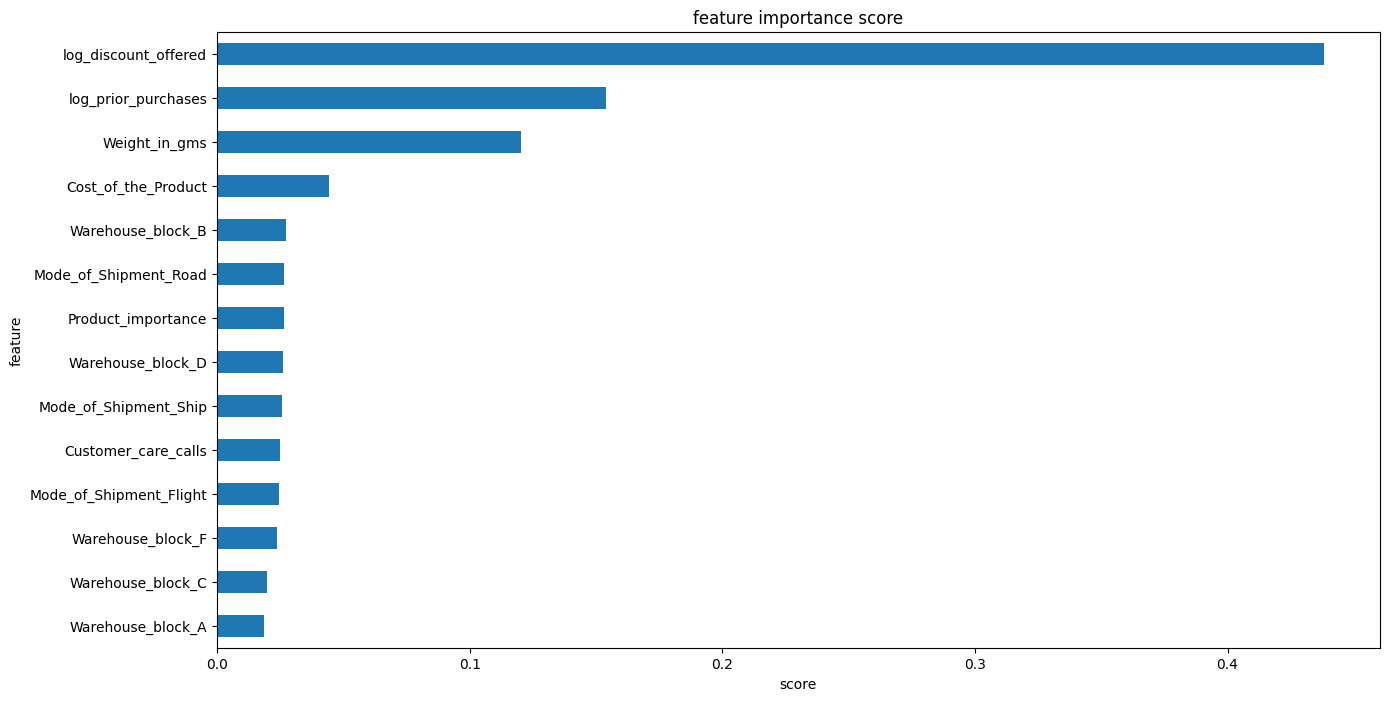

In [ ]:
show_feature_importance(model_lgb.best_estimator_)

# Logistic Regression

In [ ]:
def model_evaluation(model, y_pred, xtrain, ytrain, xtest, ytest):
    print('Accuracy : %.2f' % accuracy_score(y_test, y_pred))
    print('Precision : %.2f' % precision_score(y_test, y_pred))
    print('Recall : %.2f' % recall_score(y_test, y_pred))
    print('F-1Score : %.2f' % f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    print('ROC AUC : %.2f' % auc(fpr, tpr))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)


LogisticRegression()

In [ ]:
y_pred = model_LR.predict(X_test)

## Evaluasi Model LR

### Confusion Matrix

In [ ]:
confusion_matrix(y_test, y_pred)

array([[391, 456],
       [360, 922]])

Confusion Matrix (Test set) for LR model::
[[391 456]
 [360 922]]


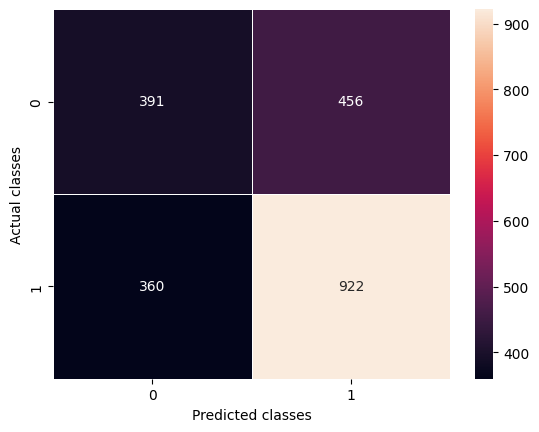

In [ ]:
## Test SET
predicted_test_classes_lr = model_LR.predict(X_test)

## Confusion Matrix
print("Confusion Matrix (Test set) for LR model::")
conf_mat_test_lr = confusion_matrix(y_test.tolist(),predicted_test_classes_lr)
print(conf_mat_test_lr)

sns.heatmap(conf_mat_test_lr,annot = True,fmt="d",linewidths=.5)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.show()


### Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.46      0.49       847
           1       0.67      0.72      0.69      1282

    accuracy                           0.62      2129
   macro avg       0.59      0.59      0.59      2129
weighted avg       0.61      0.62      0.61      2129



In [ ]:
print('Train score: ' + str(model_LR.score(X_train, y_train))) #accuracy
print('Test score:' + str(model_LR.score(X_test, y_test))) #accuracy

Train score: 0.6307999530130389
Test score:0.6167214654767497


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc

In [ ]:
model_evaluation(model_LR, y_pred, X_train, y_train, X_test, y_test)

Accuracy : 0.62
Precision : 0.67
Recall : 0.72
F-1Score : 0.69
ROC AUC : 0.59


In [ ]:
from sklearn.model_selection import cross_val_score

# Lakukan cross-validation untuk mengevaluasi model
cv_scores_train = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='recall')
cv_scores_test = cross_val_score(model_LR, X_test, y_test, cv=5, scoring='recall')

# Hitung rata-rata skor cross-validation
mean_cv_score_train = np.mean(cv_scores_train)
mean_cv_score_test = np.mean(cv_scores_test)

# Bandingkan skor pelatihan dan skor pengujian
print(f'Mean Recall Train: {mean_cv_score_train:.2f}')
print(f'Mean Recall Test: {mean_cv_score_test:.2f}')

# Jika perbedaan antara skor pelatihan dan skor pengujian signifikan, itu bisa menjadi indikasi overfitting
if mean_cv_score_train - mean_cv_score_test > 0.1:
    print('Model cenderung overfitting.')
else:
    print('Model tidak cenderung overfitting.')

Mean Recall Train: 0.72
Mean Recall Test: 0.76
Model tidak cenderung overfitting.


## With HyperParameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002] # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C )

# Inisiasi model
logres = LogisticRegression(random_state=42) # Init Logres dengan Gridsearch, cross validation = 5
model_HP = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='recall')

# Fitting Model & Evaluation
model_HP.fit(X_train, y_train)
y_pred = model_HP.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       847
           1       0.60      1.00      0.75      1282

    accuracy                           0.60      2129
   macro avg       0.30      0.50      0.38      2129
weighted avg       0.36      0.60      0.45      2129



In [ ]:
print('Train score: ' + str(model.score(X_train, y_train))) #recall
print('Test score:' + str(model.score(X_test, y_test))) #recall

In [ ]:
model_evaluation(model, y_pred, X_train, y_train, X_test, y_test)

In [ ]:
# Lakukan cross-validation untuk mengevaluasi model
cv_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
cv_scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='recall')

# Hitung rata-rata skor cross-validation
mean_cv_score_train = np.mean(cv_scores_train)
mean_cv_score_test = np.mean(cv_scores_test)

# Bandingkan skor pelatihan dan skor pengujian
print(f'Mean Recall Train: {mean_cv_score_train:.2f}')
print(f'Mean Recall Test: {mean_cv_score_test:.2f}')

# Jika perbedaan antara skor pelatihan dan skor pengujian signifikan, itu bisa menjadi indikasi overfitting
if mean_cv_score_train - mean_cv_score_test > 0.1:
    print('Model cenderung overfitting.')
else:
    print('Model tidak cenderung overfitting.')

### Confusion matrix with Hyperparameters

In [ ]:
## Test SET
predicted_test_classes_lr = model.predict(X_test)

## Confusion Matrix
print("Confusion Matrix (Test set) for LR model::")
conf_mat_test_lr = confusion_matrix(y_test.tolist(),predicted_test_classes_lr)
print(conf_mat_test_lr)

sns.heatmap(conf_mat_test_lr,annot = True,fmt="d",linewidths=.5)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.show()